This dataset includes 2708 scientific papers classified in 7 classes with 5429 links. We train the model to be able to classify them

In [ ]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

We use the Cora dataset, with 2708 scientific papers that are already classified in 7 classes with 5429 links.

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

Since the dataset includes two files:

- cora.cites: Citation records
- cora.content: Paper content records

Get citations data

In [7]:
citations_data = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

In [8]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers_data = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)

In the description of the data, we can see that the data frame has two variables target and source and the count of the total values are 5429. Let’s convert the core content into a data frame.

In [9]:
print("Papers shape:", papers_data.shape)
citations_data.sample(frac=1).head()

Papers shape: (2708, 1435)


,target,source
333,940,28265
3714,80491,7532
1940,13658,1120431
3529,67245,67246
5417,853114,19621


Now we provide label encoding to paper ids and subject columns.

In [10]:
class_values = sorted(papers_data["subject"].unique())
class_idc = {name: id for id, name in enumerate(class_values)}
paper_idc = {name: idx for idx, name in enumerate(sorted(papers_data["paper_id"].unique()))}
papers_data["paper_id"] = papers_data["paper_id"].apply(lambda name: paper_idc[name])
citations_data["source"] = citations_data["source"].apply(lambda name: paper_idc[name])
citations_data["target"] = citations_data["target"].apply(lambda name: paper_idc[name])
papers_data["subject"] = papers_data["subject"].apply(lambda value: class_idc[value])

Visualize the graph

In [11]:
plt.figure(figsize=(30, 30))

<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

In [12]:
cora_graph = nx.from_pandas_edgelist(citations_data.sample(n=1500))

In [13]:
subjects = list(papers_data[papers_data["paper_id"].isin(list(cora_graph.nodes))]["subject"])

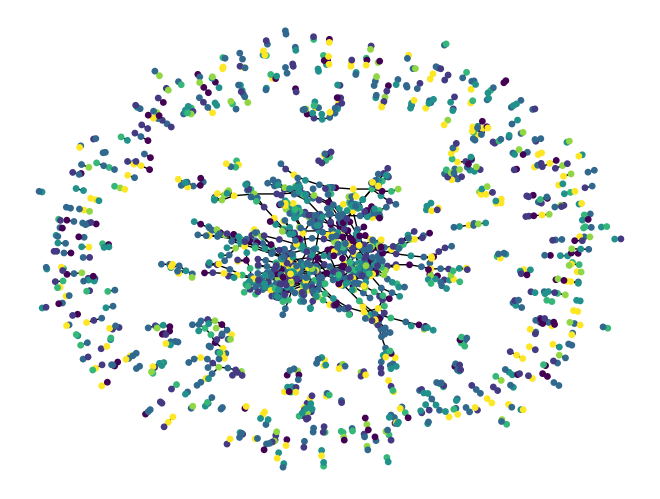

In [14]:
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

Colours of the nodes represent different subjects in the data

Links are the paper citations.

In [15]:
feature_names = set(papers_data.columns) - {"paper_id", "subject"}

Edges

In [16]:
edges = citations_data[["source", "target"]].to_numpy().T

Node features 

In [17]:
node_features = tf.cast(
    papers_data.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
print("Nodes shape:", node_features.shape)

Nodes shape: (2708, 1433)


2024-12-12 10:59:35.356552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-12 10:59:35.356591: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-12-12 10:59:35.356634: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vadalog-parallel-jupyter-deployment-adriano-67b7596fd-6zwgl): /proc/driver/nvidia/version does not exist
2024-12-12 10:59:35.357970: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 10:59:35.374124: W tensorflow/core/framework

Edge weight

In [18]:
edge_weights = tf.ones(shape=edges.shape[1])

Now we create a graph info tuple that consists of the above-given elements.



In [19]:
graph_info = (node_features, edges, edge_weights)

Now we are ready to train a graph neural network using the above graph data. For this, we need to build the neural network and we must set up the layer accordingly.

- First and foremost, we use a feed-forward neural network to produce a message and process input node representations. The shape of the node representation will be [num_nodes, representation_dim].
- Secondly, we aggregate the messages provided by the node to its neighbour node using the edge weights. These operations create a single aggregated message for each node. The shape of the aggregated messages will be [num_nodes, representation_dim].
- Then, we update the state of the node, combining node representation and aggregated messages. Basically, if the we are combining Gated Recurrent Units (GRU), then node representations and aggregated messages can be stacked to create a sequence and processed by a GRU layer. 
- For performing these tasks, we use a graph convolutional layer (in particular, Keras layer) consisting of prepare, aggregate, and update functions. 

Graph neural node classifier 
After making the layer we are required to make a graph neural node classifier. This classifier can follow the following processes:

Preprocessing of the node features to generate the node representation.
Applying graph layers.
Post-processing of the node representation to generate final node representations.
Using a softmax layer to produce the predictions based on the node represention

Start User Helping functions

In [20]:
train, test = [], []

for _, group in papers_data.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group.index)) <= 0.5
    train.append(group[random_selection])
    test.append(group[~random_selection])

train = pd.concat(train).sample(frac=1)
test = pd.concat(test).sample(frac=1)

print("Train data shape:", train.shape)
print("Test data shape:", test.shape)

Train data shape: (1379, 1435)
Test data shape: (1329, 1435)


In [21]:
feature_names = set(papers_data.columns) - {"paper_id", "subject"}
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations_data[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers_data.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


2024-12-12 10:59:35.601439: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 31044512 exceeds 10% of free system memory.


In [22]:
print("Edges_weights shape:", edge_weights.shape)

Edges_weights shape: (5429,)


In [23]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [24]:
###################
# GraphConvLayer #
#################
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [25]:
######################
# GNNNodeClassifier #
####################
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


END User Helping functions

Instantiating GNN model


In [26]:
#num_features = len(feature_names)
num_classes = len(class_idc)
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = 256

In [27]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)
print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[ 0.15875667 -0.06360336  0.05832123 -0.07520341 -0.09047884 -0.03036728
   0.10416692]
 [ 0.00759377  0.0387824  -0.13850686 -0.06201829 -0.07556772 -0.14749722
  -0.03163425]
 [-0.02713171  0.07205045 -0.02103448  0.08320327  0.00498501  0.06053734
   0.04228688]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (2708, 32)                52804     
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (2708, 32)                2368      
____________________________________________________________

Defining training data 

In [28]:
x_train = train.paper_id.to_numpy()
y_train = train["subject"]

Defining function for compiling and fitting the model


In [29]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )
 
    return history

Training model 


In [30]:
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/50


2024-12-12 10:59:36.313875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-12-12 10:59:36.338269: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2999995000 Hz


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
5/5 [==============================] - 3s 150ms/step - loss: 2.4093 - acc: 0.1365 - val_loss: 1.8960 - val_acc: 0.2899
Epoch 2/50
5/5 [==============================] - 0s 55ms/step - loss: 2.0188 - acc: 0.2355 - val_loss: 1.8597 - val_acc: 0.2899
Epoch 3/50
5/5 [==============================] - 0s 53ms/step - loss: 1.9291 - acc: 0.2705 - val_loss: 1.8493 - val_acc: 0.2899
Epoch 4/50
5/5 [==============================] - 0s 59ms/step - loss: 1.8990 - acc: 0.2952 - val_loss: 1.8469 - val_acc: 0.2899
Epoch 5/50
5/5 [==============================] - 0s 54ms/step - loss: 1.8537 - acc: 0.2901 - val_loss: 1.8518 - val_acc: 0.2899
Epoch 6/50
5/5 [==============================] - 0s 53ms/step - loss: 1.8560 - acc: 0.2807 - val_loss: 1.8541 - val_acc: 0.2899
Epoch 7/50
5/5 [==============================] - 0s 54ms/step - loss: 1.8534 - acc: 0.2995 - val_

Visualizing the results 


Text(0, 0.5, 'Loss')

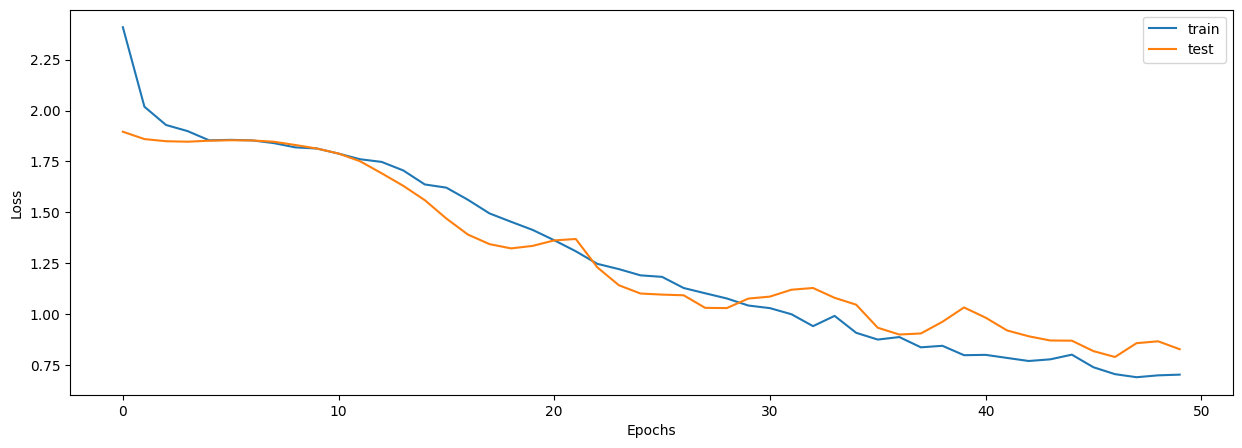

In [31]:
fig, ax1 = plt.subplots(1, figsize=(15, 5))
ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "test"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

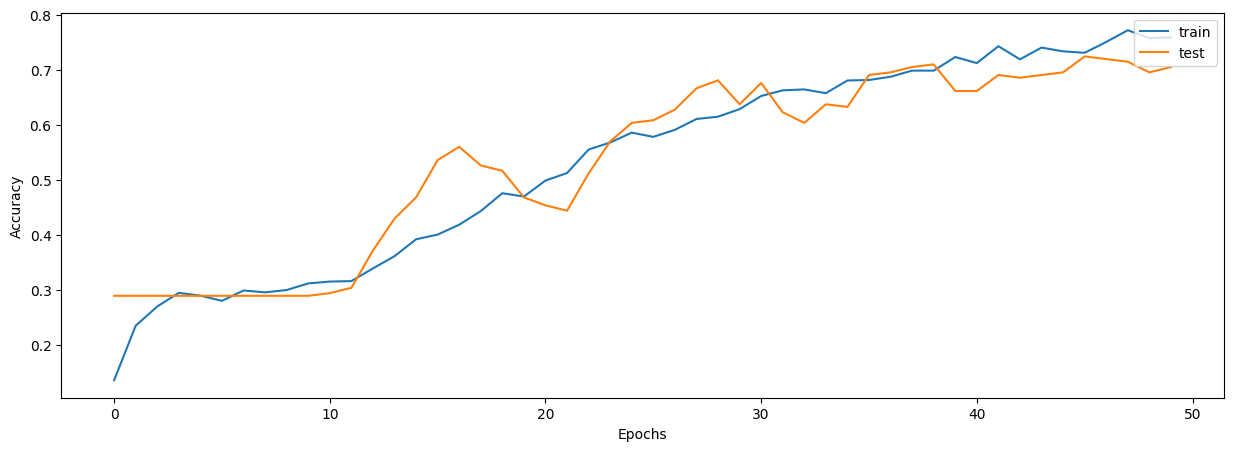

In [32]:
fig, ax2 = plt.subplots(1, figsize=(15, 5))
ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.legend(["train", "test"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()